In [2]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

import bacco
import baccoemu

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import utils
import plotter

%load_ext autoreload
%autoreload 2

Importing pyfftw first


2024-06-13 15:07:02.316925: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-13 15:07:07.899447: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-13 15:07:07.906270: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-13 15:07:53.541663: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-06-13 15:08:37.224444: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gp

### Set up bacco: cosmology and power spectrum parameters

In [3]:
## NEW MOCKS from marcos

idx_LH = 0
idx_LH_str = str(idx_LH)
tag_mocks = ''
dir_mocks = f'/cosmos_storage/cosmosims/map2map_cosmolib'

tag_fields = ''
tag_fields_hr = '_hr'
tag_fields_extra = ''

#tag_mocks_hr = '_HR'
dir_mocks_hr = dir_mocks

# order of saved cosmo param files
param_names_all = ['omega_cold', 'sigma_8', 'h', 'omega_baryon', 'n_s', 'seed']
param_names = ['omega_cold', 'sigma_8', 'h']
    
n_grid = 128
n_grid_orig = 512
box_size = 1000.0

In [4]:
# idx_LH = 0
# idx_LH_str = str(idx_LH)
# tag_mocks = ''
# dir_mocks = f'../data/cosmolib{tag_mocks}'

# tag_mocks_hr = '_HR'
# dir_mocks_hr = f'../data/cosmolib{tag_mocks_hr}'

# tag_fields = '_lr'
# tag_fields_extra = ''

# # order of saved cosmo param files
# param_names_all = ['omega_cold', 'sigma_8', 'h', 'omega_baryon', 'n_s', 'seed']
# param_names = ['omega_cold', 'sigma_8', 'h']
    
# n_grid = 128
# n_grid_orig = 512
# box_size = 1000.0



In [5]:
def get_cosmo(param_dict):
    a_scale = 1
    # omega_m = omega_cold + omega_neutrinos 
    # (omega_m = omega_cold if no neutrinos) 
    # Om_cdm = Om_cold - Om_baryon
    if 'omega_m' in param_dict:
        omega_cdm = param_dict['omega_m']-param_dict['omega_baryon']
    elif 'omega_cold' in param_dict:
        omega_cdm = param_dict['omega_cold']-param_dict['omega_baryon']
    else:
        raise ValueError("param_dict must include omega_m or omega_cold!")

    cosmopars = dict(
            omega_cdm=omega_cdm,
            omega_baryon=param_dict['omega_baryon'],
            hubble=param_dict['h'],
            ns=param_dict['n_s'],
            sigma8=param_dict['sigma_8'],
            tau=0.0561,
            A_s=None,
            neutrino_mass=0.,
            w0=-1,
            wa=0,
        )

    cosmo = bacco.Cosmology(**cosmopars)
    cosmo.set_expfactor(a_scale)
    return cosmo

In [6]:
fn_params = f'{dir_mocks}/LH{idx_LH}/cosmo_{idx_LH}.txt'
param_vals = np.loadtxt(fn_params)
param_dict = dict(zip(param_names_all, param_vals))
del param_dict['seed']
print(param_dict)
cosmo_Quijote = get_cosmo(param_dict)


2024-06-12 23:18:00,469 bacco.cosmo :    initialization took 0.000 secs


{'omega_cold': 0.26844362773678837, 'sigma_8': 0.7566061112802549, 'h': 0.7511702287380517, 'omega_baryon': 0.049, 'n_s': 0.9624}


In [7]:
k_min = 0.01
k_max = 1.0
n_bins = 30
log_binning = True
n_threads = 4

deposit_method = 'cic'
interlacing = False
correct_grid = True
deconvolve_grid = True
normalise_grid = True

# defaults from bacco.statistics.compute_power
# unless passed or otherwise denoted
args_power = {
    "ngrid": n_grid,
    "box": box_size,
    #"pos": None,
    "vel": None,
    "mass": None,
    "interlacing": interlacing, #default: None
    "unit_in_Mpc": 1,
    "deposit_method": deposit_method, # default: 'cic',
    "bs_method": None,
    "bs_num_triangles": 10000,
    "bs_k1": 0.01,
    "bs_k2": None,
    "bs_deltak": None,
    "log_binning": log_binning,
    "kmin": k_min,
    "kmax": k_max,
    "nbins": n_bins,
    "correct_grid": correct_grid, #default: True,
    "deconvolve_grid": deconvolve_grid, #default: True,
    "normalise_grid": normalise_grid, #default: True,
    "totalmass": None,
    "correct_shotnoise": False,
    "zspace": False,
    "cosmology": cosmo_Quijote,
    "pmulti_interp": "polyfit",
    "nthreads": n_threads,
    "grid1": None,
    "dilution": None,
    "folds": None,
    "compute_correlation": False, #default: True
    "compute_power2d": False, #default: True
    "jack_error": False,
    "n_jack": None
}

# defaults from bacco.statistics.compute_crossspectrum_twogrids
# unless passed or otherwise denoted
args_power_grid = {
    # "grid1": None,
    # "grid2": None,
    "normalise_grid1": normalise_grid, #default: False
    "normalise_grid2": normalise_grid, #default: False
    "deconvolve_grid1": deconvolve_grid, #default: False
    "deconvolve_grid2": deconvolve_grid, #default: False
    "ngrid": n_grid,
    "box": box_size,
    "mass1": None,
    "mass2": None,
    "interlacing": interlacing, #default: True
    "deposit_method": deposit_method, #default: "tsc",
    "log_binning": log_binning,
    "pk_lt": None,
    "kmin": k_min,
    "kmax": k_max,
    "nbins": n_bins,
    "correct_grid": correct_grid,
    "zspace": False,
    "cosmology": cosmo_Quijote,
    "pmulti_interp": "polyfit",
    "nthreads": n_threads,
    "compute_correlation": False, #default: True
    "compute_power2d": False, #default: True
    "folds": 1,
    "totalmass1": None,
    "totalmass2": None,
    "jack_error": False,
    "n_jack": None
}

pknbody_dict = {
    'ngrid': n_grid,
    'min_k': k_min,
    'log_binning': log_binning,
    'log_binning_kmax': k_max,
    'log_binning_nbins': n_bins,
    'interlacing': interlacing,
    'depmethod': deposit_method,
    'correct_grid': correct_grid,
    'folds': 1 #default
}
bacco.configuration.update({'number_of_threads': n_threads})
bacco.configuration.update({'pknbody': pknbody_dict})
bacco.configuration.update({'pk' : {'maxk' : k_max}})
bacco.configuration.update({'scaling' : {'disp_ngrid' : n_grid}})


## Load eulerian fields

In [58]:
def get_tracer_field(bias_fields_eul, bias_vector, n_grid_norm=512):

    def _sum_bias_fields(fields, bias_vector):
        bias_vector_extended = np.concatenate(([1.0], bias_vector))
        return np.sum([fields[ii]*bias_vector_extended[ii] for ii in range(len(bias_vector))], axis=0)
    
    tracer_field_eul = _sum_bias_fields(bias_fields_eul, bias_vector)
    tracer_field_eul_norm = tracer_field_eul/n_grid_norm**3
    
    return tracer_field_eul_norm

In [12]:

fn_fields = f'{dir_mocks}/LH{idx_LH}/Eulerian_fields{tag_fields}_{idx_LH}{tag_fields_extra}.npy'
bias_vector = [0.,0.,0.,0.]

bias_terms_eul = np.load(fn_fields)
print(bias_terms_eul.shape)
if n_grid_orig is None:
    n_grid_orig = bias_terms_eul.shape[-1]
print(f"n_grid_orig = {n_grid_orig}")
tracer_field = get_tracer_field(bias_terms_eul, bias_vector, n_grid_norm=n_grid_orig)
print(tracer_field.shape)

(5, 128, 128, 128)
n_grid_orig = 512
(128, 128, 128)


In [15]:
fn_fields_hr = f'{dir_mocks_hr}/LH{idx_LH}/Eulerian_fields{tag_fields_hr}_{idx_LH}{tag_fields_extra}.npy'
bias_vector = [0.,0.,0.,0.]

bias_terms_eul_hr = np.load(fn_fields_hr)
print(bias_terms_eul_hr.shape)
bias_terms_eul_hr = np.squeeze(bias_terms_eul_hr)
print(bias_terms_eul_hr.shape)

if n_grid_orig is None:
    n_grid_orig = bias_terms_eul_hr.shape[-1]
print(f"n_grid_orig = {n_grid_orig}")
tracer_field_hr = get_tracer_field(bias_terms_eul_hr, bias_vector, n_grid_norm=n_grid_orig)
print(tracer_field_hr.shape)

(5, 1, 512, 512, 512)
(5, 512, 512, 512)
n_grid_orig = 512
(512, 512, 512)


Put displacements on mesh

-3.9792216739442665e-06 1.98344550881302e-05
-3.9792216739442665e-06 1.98344550881302e-05


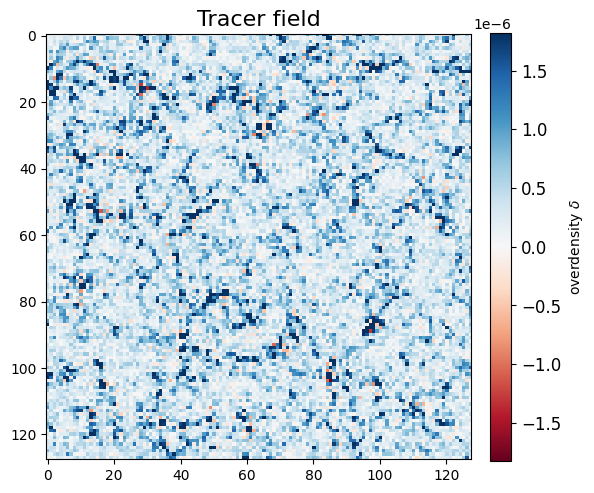

In [16]:
plotter.plot_overdensity_field(tracer_field, title=r'Tracer field',
                               #vmax=0.1
                               )

0.0 6.3190727814799175e-06
0.0 6.3190727814799175e-06


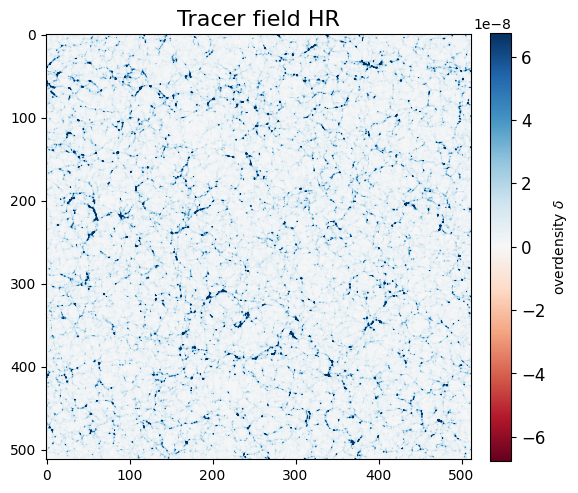

In [17]:
plotter.plot_overdensity_field(tracer_field_hr, title=r'Tracer field HR',
                               #vmax=0.1
                               )

### Compute power spectra of fields

In [18]:
pk_obj_mesh = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field,
                    grid2=tracer_field,
                    **args_power_grid)

2024-06-12 18:39:59,171 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2024-06-12 18:39:59,719 bacco.cosmo :    computed CAMB power spectrum at z=0.00 in 0.438 secs
2024-06-12 18:39:59,722 bacco.cosmo :    created Pk(z=0) tab from k 6.656281038885936e-05 to 100000.0 h/Mpc
2024-06-12 18:39:59,726 bacco.cosmo :    computed halofit at z=0.00 for 'Default' in 0.002 secs
2024-06-12 18:39:59,849 bacco.statistics :  ...done in 0.678 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.007475 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.044590 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000139 secs
bacco.power : Deallocating arrays


In [19]:
args_power_grid_deconvolveFalse = args_power_grid.copy()
args_power_grid_deconvolveFalse['deconvolve_grid1'] = False
args_power_grid_deconvolveFalse['deconvolve_grid2'] = False

pk_obj_mesh_deconvolveFalse = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field,
                    grid2=tracer_field,
                    **args_power_grid_deconvolveFalse)

2024-06-12 18:40:01,209 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2024-06-12 18:40:01,324 bacco.statistics :  ...done in 0.115 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.012255 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.043396 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000312 secs
bacco.power : Deallocating arrays


In [20]:
args_power_grid_correctgridTrue = args_power_grid.copy()
args_power_grid_correctgridTrue['correct_grid'] = True

pk_obj_mesh_correctgridTrue = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field,
                    grid2=tracer_field,
                    **args_power_grid_correctgridTrue)

2024-06-12 18:40:02,594 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2024-06-12 18:40:02,718 bacco.statistics :  ...done in 0.123 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.012550 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.044747 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000293 secs
bacco.power : Deallocating arrays


In [21]:
print("hi")

hi


In [38]:
args_power_grid_hr = args_power_grid.copy()
args_power_grid_hr['ngrid'] = 512

In [23]:

pk_obj_mesh_hr = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field_hr,
                    grid2=tracer_field_hr,
                    **args_power_grid_hr)

2024-06-12 18:40:06,608 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.994721 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.758184 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000390 secs
bacco.power : Deallocating arrays


2024-06-12 18:40:13,699 bacco.statistics :  ...done in 7.09 s


In [24]:
args_power_grid_hr_deconvolveFalse = args_power_grid_hr.copy()
args_power_grid_hr_deconvolveFalse['deconvolve_grid1'] = False
args_power_grid_hr_deconvolveFalse['deconvolve_grid2'] = False

pk_obj_mesh_hr_deconvolveFalse = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field_hr,
                    grid2=tracer_field_hr,
                    **args_power_grid_hr_deconvolveFalse)

2024-06-12 18:40:14,912 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.978151 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.777231 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000149 secs
bacco.power : Deallocating arrays


2024-06-12 18:40:22,300 bacco.statistics :  ...done in 7.39 s


### Load in emulators, compute emu P(k)'s

In [14]:
emu_mpk_ext, emu_bounds_mpk_ext, emu_param_names_mpk_ext = utils.load_emu(emu_name='mpk_extended')
emu_bounds_dict_mpk_ext = dict(zip(emu_param_names_mpk_ext, emu_bounds_mpk_ext))

Loading sigma8 emulator...
HIIII
Sigma8 emulator loaded in memory.
Loading linear emulator...


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using v

Linear emulator loaded in memory.
Loading no-wiggles emulator...


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


No-wiggles emulator loaded in memory.
Loading non-linear emulator...
Nonlinear emulator loaded in memory.
Loading Baryonic Emulator...
Baryonic Emulator loaded in memory.


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.23.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [15]:
# Careful, these are diff than quijote, so order of running this nb matters
param_names_2_emu_param_names = {'sigma_8': 'sigma8_cold',
                                 'omega_cold': 'omega_cold',
                                 'h': 'hubble',
                                 'n_s': 'ns',
                                 'omega_baryon': 'omega_baryon'
                                 }

In [16]:
kk = pk_obj_mesh['k']

NameError: name 'pk_obj_mesh' is not defined

In [ ]:

cosmo_params = {
    'neutrino_mass' :  0.0,
    'w0'            : -1.0,
    'wa'            :  0.0,
    'expfactor'     :  1
}

In [ ]:
param_names_fromdict = list(param_dict.keys())

#for param_name in param_names:
for param_name in param_names_fromdict:
    if param_name=='omega_m':
        # no neutrinos, so omega_cold = omega_m
        emu_param_name = 'omega_cold'
    else:
        emu_param_name = param_names_2_emu_param_names[param_name]
    cosmo_params[emu_param_name] = param_dict[param_name]

_, pk_emu, = emu_mpk_ext.get_nonlinear_pk(k=kk, cold=True,
                                                        **cosmo_params)

### Check cosmos

In [30]:
param_dict

{'omega_cold': 0.26844362773678837,
 'sigma_8': 0.7566061112802549,
 'h': 0.7511702287380517,
 'omega_baryon': 0.049,
 'n_s': 0.9624}

In [31]:
cosmo_params

{'neutrino_mass': 0.0,
 'w0': -1.0,
 'wa': 0.0,
 'expfactor': 1,
 'omega_cold': 0.26844362773678837,
 'sigma8_cold': 0.7566061112802549,
 'hubble': 0.7511702287380517,
 'omega_baryon': 0.049,
 'ns': 0.9624}

In [32]:
cosmo_Quijote.pars

{'hubble': 0.7511702287380517,
 'sigma8': 0.7566061112802549,
 'A_s': None,
 'omega_baryon': 0.049,
 'omega_cdm': 0.21944362773678838,
 'w0': -1,
 'wa': 0,
 'ns': 0.9624,
 'tau': 0.0561,
 'approx_nu': False,
 'num_massive_neutrinos': 0,
 'neutrino_mass': 0.0,
 'Neffective': 3.046,
 'DeltaNeff': 3.046,
 'GammaNu': 0.71611,
 'omega_neutrino': 0.0,
 'omega_matter': 0.26844362773678837,
 'omega_cold': 0.26844362773678837,
 'photon_temperature': 2.7255,
 'omega_photons': 0.0,
 'omega_rad': 0.0,
 'omega_de': 0.7315563722632117,
 'omega_k': 0.0,
 'omega_tot': 1.0}

### Plot

/tmp/ipykernel_56591/4066074678.py:63: RuntimeWarning: divide by zero encountered in divide
  ax1.plot(ks[i], (pk_emu-pks[i])/errs[i], ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i])
/tmp/ipykernel_56591/4066074678.py:64: RuntimeWarning: divide by zero encountered in divide
  ax2.plot(ks[i], (pk_emu/pks[i]), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i])


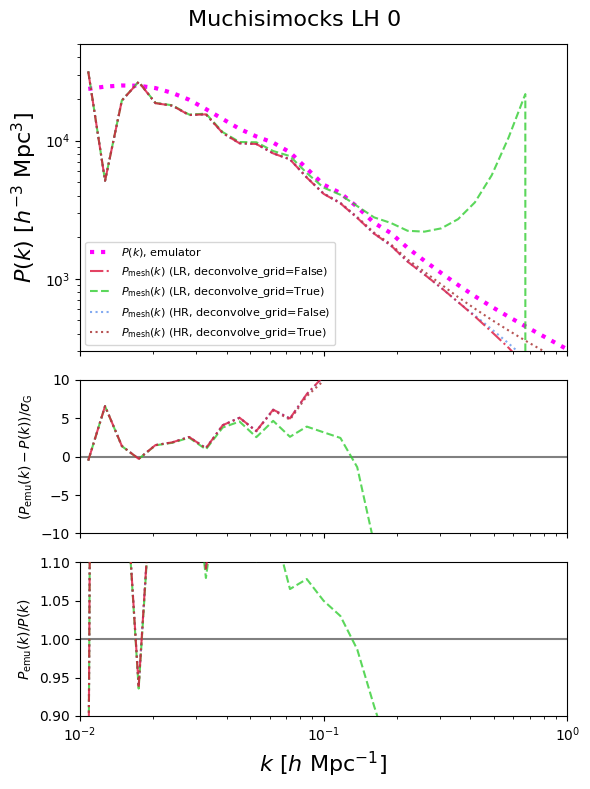

In [33]:
nrows, ncols = 3, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(6,8), sharex=True, height_ratios=[2,1,1])
plt.subplots_adjust(hspace=0.01, wspace=0.01)
ax, ax1, ax2 = axarr
alpha = 0.8

# labels = [r'$P_\text{part}(k)$ (deconvolve_grid=False)', 
#           #r'$P_\text{mesh}(k)$ (deconvolve_grid=False)', 
#           r'$P_\text{part}(k)$ (deconvolve_grid=True)',
#           r'$P_\text{part}(k)$ (deconvolve_grid=True,'+'\n interlacing=True)',
#           r'$P_\text{part}(k)$ (deconvolve_grid=True,'+'\n correct_grid=False)',
#           r'$P_\text{mesh}(k)$ (deconvolve_grid=True)',
#           r'$P_\text{part}(k)$ (deconvolve_grid=True),'+'\n from Quijote snapshot',
#           ]
labels = [r'$P_\text{mesh}(k)$ (LR, deconvolve_grid=False)',
          r'$P_\text{mesh}(k)$ (LR, deconvolve_grid=True)',
          #r'$P_\text{mesh}(k)$ (deconvolve_grid=True, correct_grid=True)',
          r'$P_\text{mesh}(k)$ (HR, deconvolve_grid=False)',
          r'$P_\text{mesh}(k)$ (HR, deconvolve_grid=True)']
colors = ['crimson', 'limegreen', 'cornflowerblue', 'brown', 'orange', 'darkblue',]
lss = ['-.', '--', ':', ':', '--', '-']
# pk_objs = [pk_obj_particles_nodeconv,
#            pk_obj_particles,
#            pk_obj_particles_interlacing,
#            pk_obj_particles_nocorrectgrid,
#            pk_obj_mesh, 
#            #pk_obj_particles_deconv_Mpcperh, 
#            #pk_obj_pos_mesh_deconv, 
#            pk_obj_snap,
#            ]
pk_objs = [pk_obj_mesh_deconvolveFalse,
           pk_obj_mesh,
           #pk_obj_mesh_correctgridTrue,
           pk_obj_mesh_hr_deconvolveFalse,
           pk_obj_mesh_hr
           ]
zorders = list(range(len(pk_objs),0,-1))
ks = [pk_obj['k'] for pk_obj in pk_objs]
pks = [pk_obj['pk'] for pk_obj in pk_objs]
errs = [pk_obj['pk_gaussian_error'] for pk_obj in pk_objs]

# ks.append(k_quijote)
# pks.append(pk_quijote)
# errs.append(err_quijote)
# #errs.append(bacco.statistics.approx_pk_gaussian_error(k_quijote, pk_quijote, box_size))
# labels.append(r'$P(k)$, Quijote measured')
# colors.append('grey')
# lss.append('-')
# zorders.append(0)

plt.suptitle(f'Muchisimocks LH {idx_LH_str}', fontsize=16)

ax.loglog(kk, pk_emu, label=r'$P(k)$, emulator', ls=':', color='magenta', lw=3)

for i in range(len(pks)):
    ax.loglog(ks[i], pks[i], ls=lss[i], label=labels[i], color=colors[i], alpha=alpha, zorder=zorders[i])
    if len(pk_emu)!=len(pks[i]):
        pk_interp = np.interp(kk, ks[i], pks[i])
        err_interp = np.interp(kk, ks[i], errs[i])
        ax1.plot(kk, (pk_emu-pk_interp)/err_interp, ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i])
        ax2.plot(kk, (pk_emu/pk_interp), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i])
    else:
        ax1.plot(ks[i], (pk_emu-pks[i])/errs[i], ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i])
        ax2.plot(ks[i], (pk_emu/pks[i]), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i])


ax1.axhline(0.0, color='grey')
ax2.axhline(1.0, color='grey')

ax2.set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=16)
ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)
ax1.set_ylabel(r'$(P_\text{emu}(k)-P(k))/\sigma_\text{G}$')
ax2.set_ylabel(r'$P_\text{emu}(k)/P(k)$')
ax.set_xlim(1e-2, 1)
ax.set_ylim(3e2, 5e4)

ax1.set_ylim(-10, 10)
ax2.set_ylim(0.9, 1.1)

ax.legend(fontsize=8, loc='lower left')

mpl.pyplot.tight_layout()
mpl.pyplot.show()

### New plan, back to the pred_disp field, bc worked from there for quijote

In [30]:
idx_LH = 0
idx_LH_str = str(idx_LH)

# order of saved cosmo param files
param_names_all = ['omega_cold', 'sigma_8', 'h', 'omega_baryon', 'n_s', 'seed']
param_names = ['omega_cold', 'sigma_8', 'h']
    
n_grid = 512
n_grid_orig = 512
box_size = 1000.0

In [45]:
# Quijote LH test data

# still had LH0 in map2map emu dir, preeeetty sure its LH0 cosmo params

dir_mocks = f'/dipc/kstoreyf/muchisimocks/data/cosmolib_rerun'
dir_params = f'/dipc/kstoreyf/muchisimocks/data/cosmolib'

fn_sim = f'{dir_mocks}/LH{idx_LH}/pred_disp.npy'
sim_disp = np.load(fn_sim)

fn_dens = f'{dir_mocks}/LH{idx_LH}/lin_field.npy'
dens_lin = np.load(fn_dens)

In [49]:
fn_params = f'{dir_params}/LH{idx_LH}/cosmo_{idx_LH}.txt'
param_vals = np.loadtxt(fn_params)
param_dict = dict(zip(param_names_all, param_vals))
#del param_dict['seed']
print(param_dict)
cosmo = get_cosmo(param_dict)


2024-06-13 00:18:25,258 bacco.cosmo :    initialization took 0.000 secs


{'omega_cold': 0.2775274936564327, 'sigma_8': 0.7049140324569382, 'h': 0.7241123952301097, 'omega_baryon': 0.049, 'n_s': 0.9624, 'seed': 0.0}


In [33]:

cosmo_params = {
    'neutrino_mass' :  0.0,
    'w0'            : -1.0,
    'wa'            :  0.0,
    'expfactor'     :  1
}

In [34]:
# copied from DataCreationPipeline.py

## Create regular grid and displace particles
print("Generating grid")
grid = bacco.visualization.uniform_grid(npix=n_grid, L=box_size, ndim=3, bounds=False)

print("Adding predicted displacements")
sim_pos = bacco.scaler.add_displacement(None,
                                    sim_disp,
                                    box=box_size,
                                    pos=grid.reshape(-1,3),
                                    vel=None,
                                    vel_factor=0,
                                    verbose=True)[0]

Generating grid


2024-06-12 23:25:47,297 bacco.scaler : Adding displacement field with a vel-factor=0.000000


Adding predicted displacements
bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


In [35]:
sim_pos_mesh = bacco.statistics.compute_mesh(ngrid=n_grid, box=box_size, pos=sim_pos, vel=None, mass=None,
                 interlacing=False, deposit_method='cic', folds=1,
                 zspace=False, cosmology=None, nthreads=None, twod=False)
print(sim_pos_mesh.shape)

2024-06-12 23:25:52,955 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-06-12 23:25:52,956 bacco.statistics : starting deposit 1
2024-06-12 23:25:57,012 bacco.statistics :  mesh done in 4.06 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=4, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
(1, 512, 512, 512)


In [74]:

pk_obj_mesh_fromdisp_hr = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=sim_pos_mesh,
                    grid2=sim_pos_mesh,
                    **args_power_grid_hr)

2024-06-13 00:37:07,438 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.109016 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.873840 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000285 secs
bacco.power : Deallocating arrays


2024-06-13 00:37:12,551 bacco.statistics :  ...done in 5.11 s


In [75]:
args_power_grid_hr_deconvolveFalse = args_power_grid_hr.copy()
args_power_grid_hr_deconvolveFalse['deconvolve_grid1'] = False
args_power_grid_hr_deconvolveFalse['deconvolve_grid2'] = False

pk_obj_mesh_fromdisp_hr_deconvolveFalse = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=sim_pos_mesh,
                    grid2=sim_pos_mesh,
                    **args_power_grid_hr_deconvolveFalse)

2024-06-13 00:37:17,855 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.065530 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.831085 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000264 secs
bacco.power : Deallocating arrays


2024-06-13 00:37:22,662 bacco.statistics :  ...done in 4.81 s


Copy method from DataCreationPipeline

In [51]:
FixedInitialAmplitude = False
seed = int(param_dict['seed'])
sim, disp_field = bacco.utils.create_lpt_simulation(cosmo, box_size, Nmesh=n_grid, Seed=seed,
                                                    FixedInitialAmplitude=FixedInitialAmplitude,InitialPhase=0, 
                                                    expfactor=1, LPT_order=1, order_by_order=None,
                                                    phase_type=1, ngenic_phases=True, return_disp=True, 
                                                    sphere_mode=0)

2024-06-13 00:18:57,223 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
2024-06-13 00:18:57,225 bacco.sims : Initialising simulation Default
2024-06-13 00:18:57,226 bacco.sims : ...done in 0.00117 s
2024-06-13 00:19:05,149 bacco.cosmo :    computed CAMB power spectrum at z=0.00 in 0.407 secs
2024-06-13 00:19:05,151 bacco.cosmo :    created Pk(z=0) tab from k 6.905005284352228e-05 to 100000.0 h/Mpc


bacco.lss_scaler : 292 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =4; seed =0 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =0 ngrid=512 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
using passed seed

2024-06-13 00:19:26,161 bacco.scaler : Adding displacement field with a vel-factor=49.066468


bacco.lss_scaler:  Adding LSS displacement: vel_factor=49.066468 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


In [52]:
damping_scale = 0.7 #k_nyq
interlacing = False

print("Setting up bias model")
bmodel = bacco.BiasModel(sim=sim, linear_delta=dens_lin, ngrid=n_grid, ngrid1=None, 
                            sdm=False, mode="dm",
                            npart_for_fake_sim=n_grid, damping_scale=damping_scale, 
                            bias_model='expansion', deposit_method="cic", 
                            use_displacement_of_nn=False, interlacing=interlacing, 
                            )


2024-06-13 00:19:44,333 bacco.BiasModel : Initialising Bias Model class ...


Setting up bias model


In [53]:
bias_fields = bmodel.bias_terms_lag()

2024-06-13 00:20:04,876 bacco.BiasModel : Computing delta_to_tidal_field with 4 threads...
2024-06-13 00:20:04,878 bacco.BiasModel : fttw plan
2024-06-13 00:20:04,879 bacco.BiasModel : Computing linear field ...
2024-06-13 00:20:04,880 bacco.BiasModel : Memory used: 14.116409344 Gigabytes
2024-06-13 00:20:04,888 bacco.BiasModel : fttw freqs
2024-06-13 00:20:04,889 bacco.BiasModel : tidk freqs
2024-06-13 00:20:11,846 bacco.BiasModel : ifft
2024-06-13 00:20:47,550 bacco.BiasModel : Computing laplacian ...
2024-06-13 00:20:47,553 bacco.BiasModel : Memory used: 18.949926912 Gigabytes
2024-06-13 00:20:49,705 bacco.BiasModel : Computing bias terms in lagrangian coords ...
2024-06-13 00:20:49,707 bacco.BiasModel : Memory used: 19.487244288 Gigabytes
2024-06-13 00:20:49,956 bacco.BiasModel : Computing delta squared ...
2024-06-13 00:20:49,957 bacco.BiasModel : Memory used: 20.02399232 Gigabytes
2024-06-13 00:20:51,021 bacco.BiasModel : Computing tidal component G2 with the given tidal field
20

In [55]:
npart = n_grid
bias_terms_eul_pred=[]
for ii in range(0,len(bias_fields)):
    bias_terms_pred = bacco.statistics.compute_mesh(ngrid=npart, box=box_size, pos=sim_pos, 
                                mass = (bias_fields[ii]).flatten(), deposit_method='cic', 
                                interlacing=interlacing)
    bias_terms_eul_pred.append(bias_terms_pred)
bias_terms_eul_pred = np.array(bias_terms_eul_pred)

2024-06-13 00:21:25,924 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-06-13 00:21:25,925 bacco.statistics : starting deposit 1
2024-06-13 00:21:30,099 bacco.statistics :  mesh done in 4.17 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=4, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-06-13 00:21:30,719 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-06-13 00:21:30,720 bacco.statistics : starting deposit 1
2024-06-13 00:21:35,671 bacco.statistics :  mesh done in 4.95 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=4, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-06-13 00:21:36,266 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-06-13 00:21:36,268 bacco.statistics : starting deposit 1
2024-06-13 00:21:40,752 bacco.statistics :  mesh done in 4.49 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=4, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-06-13 00:21:41,560 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-06-13 00:21:41,562 bacco.statistics : starting deposit 1
2024-06-13 00:21:45,745 bacco.statistics :  mesh done in 4.18 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=4, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-06-13 00:21:46,363 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-06-13 00:21:46,364 bacco.statistics : starting deposit 1
2024-06-13 00:21:50,510 bacco.statistics :  mesh done in 4.15 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=4, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


In [56]:
from bacco.visualization import np_get_kmesh
import pyfftw
# any reason for this to be set here differently??
#ngrid=512
ngrid = n_grid
k_nyq = np.pi/1000*128
kmesh = np_get_kmesh( (ngrid, ngrid, ngrid), box_size, real=True)
mask = (kmesh[:,:,:,0]<=k_nyq) & (kmesh[:,:,:,1]<=k_nyq) & (kmesh[:,:,:,2]<=k_nyq) & (kmesh[:,:,:,0]>-k_nyq) & (kmesh[:,:,:,1]>-k_nyq) & (kmesh[:,:,:,2]>-k_nyq)
bias_terms_eul_pred_kcut=[]
for fid in range(5):
    field = bias_terms_eul_pred[fid][0]
    deltak = pyfftw.builders.rfftn(field, auto_align_input=False, auto_contiguous=False, avoid_copy=True)
    deltakcut = deltak()[mask]
    deltakcut= deltakcut.reshape(128, 128, 65)
    delta = pyfftw.builders.irfftn(deltakcut, axes=(0,1,2))()
    bias_terms_eul_pred_kcut.append(delta)
bias_terms_eul_pred_kcut = np.array(bias_terms_eul_pred_kcut)

In [62]:
bias_vector = [0.,0.,0.,0.]
if n_grid_orig is None:
    n_grid_orig = bias_terms_eul_pred.shape[-1]
print(f"n_grid_orig = {n_grid_orig}")
tracer_field_hr = get_tracer_field(bias_terms_eul_pred, bias_vector, n_grid_norm=n_grid_orig)
print(tracer_field_hr.shape)
tracer_field_hr = np.squeeze(tracer_field_hr)
print(tracer_field_hr.shape)

n_grid_orig = 512
(1, 512, 512, 512)


In [61]:
if n_grid_orig is None:
    n_grid_orig = bias_terms_eul_pred_kcut.shape[-1]
print(f"n_grid_orig = {n_grid_orig}")
tracer_field = get_tracer_field(bias_terms_eul_pred_kcut, bias_vector, n_grid_norm=n_grid_orig)
print(tracer_field.shape)

n_grid_orig = 512
(128, 128, 128)


In [63]:

pk_obj_mesh_fromdisp_tracer = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field,
                    grid2=tracer_field,
                    **args_power_grid)

2024-06-13 00:25:38,663 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2024-06-13 00:25:38,767 bacco.statistics :  ...done in 0.104 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013527 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.045994 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000138 secs
bacco.power : Deallocating arrays


In [64]:
pk_obj_mesh_fromdisp_tracer_hr = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field_hr,
                    grid2=tracer_field_hr,
                    **args_power_grid_hr)

2024-06-13 00:26:47,752 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.523488 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.798424 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000163 secs
bacco.power : Deallocating arrays


2024-06-13 00:26:56,514 bacco.statistics :  ...done in 8.76 s


In [70]:
args_power_grid_deconvolveFalse = args_power_grid.copy()
args_power_grid_deconvolveFalse['deconvolve_grid1'] = False
args_power_grid_deconvolveFalse['deconvolve_grid2'] = False

pk_obj_mesh_fromdisp_tracer_deconvolveFalse = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field,
                    grid2=tracer_field,
                    **args_power_grid_deconvolveFalse)

2024-06-13 00:29:23,499 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2024-06-13 00:29:23,607 bacco.statistics :  ...done in 0.109 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.012932 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.044646 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000141 secs
bacco.power : Deallocating arrays


In [71]:
args_power_grid_hr_deconvolveFalse = args_power_grid_hr.copy()
args_power_grid_hr_deconvolveFalse['deconvolve_grid1'] = False
args_power_grid_hr_deconvolveFalse['deconvolve_grid2'] = False

pk_obj_mesh_fromdisp_tracer_hr_deconvolveFalse = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field_hr,
                    grid2=tracer_field_hr,
                    **args_power_grid_hr_deconvolveFalse)

2024-06-13 00:29:26,116 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.093909 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.787700 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000165 secs
bacco.power : Deallocating arrays


2024-06-13 00:29:34,080 bacco.statistics :  ...done in 7.96 s


Try depositing onto finer grid, then downsampling

In [78]:
## Compute eulerian fields
print("Computing eulerian fields")
bias_terms_eul_pred_fine=[]
for ii in range(0,len(bias_fields)):
    bias_terms_pred_fine = bacco.statistics.compute_mesh(ngrid=1024, box=box_size, pos=sim_pos, 
                                mass = (bias_fields[ii]).flatten(), deposit_method='cic', 
                                interlacing=interlacing)
    bias_terms_eul_pred_fine.append(bias_terms_pred_fine)
bias_terms_eul_pred_fine = np.array(bias_terms_eul_pred_fine)

[autoreload of scipy.sparse.linalg._isolve.iterative failed: Traceback (most recent call last):
  File "/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/scipy/__init__.py", line 192, in __getattr__
    return globals()[name]
           ~~~~~~~~~^^^^^^
KeyError: '_lib'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>",

Computing eulerian fields


2024-06-13 00:55:02,774 bacco.statistics : Computing cic mesh with ngrid=1024 and interlacing=False
2024-06-13 00:55:02,776 bacco.statistics : starting deposit 1
2024-06-13 00:55:11,237 bacco.statistics :  mesh done in 8.46 s


bacco.mesh : boxsize=1000.000000 ngrid=1024, nthreads=4, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 4096.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-06-13 00:55:12,477 bacco.statistics : Computing cic mesh with ngrid=1024 and interlacing=False
2024-06-13 00:55:12,478 bacco.statistics : starting deposit 1


bacco.mesh : boxsize=1000.000000 ngrid=1024, nthreads=4, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0


2024-06-13 00:55:20,994 bacco.statistics :  mesh done in 8.52 s


bacco.mesh : allocating 4096.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-06-13 00:55:21,647 bacco.statistics : Computing cic mesh with ngrid=1024 and interlacing=False
2024-06-13 00:55:21,648 bacco.statistics : starting deposit 1


bacco.mesh : boxsize=1000.000000 ngrid=1024, nthreads=4, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 4096.0 Mb


2024-06-13 00:55:30,116 bacco.statistics :  mesh done in 8.47 s


bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-06-13 00:55:30,755 bacco.statistics : Computing cic mesh with ngrid=1024 and interlacing=False
2024-06-13 00:55:30,756 bacco.statistics : starting deposit 1
2024-06-13 00:55:38,917 bacco.statistics :  mesh done in 8.16 s


bacco.mesh : boxsize=1000.000000 ngrid=1024, nthreads=4, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 4096.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-06-13 00:55:39,488 bacco.statistics : Computing cic mesh with ngrid=1024 and interlacing=False
2024-06-13 00:55:39,489 bacco.statistics : starting deposit 1
2024-06-13 00:55:47,858 bacco.statistics :  mesh done in 8.37 s


bacco.mesh : boxsize=1000.000000 ngrid=1024, nthreads=4, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 4096.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


In [80]:
bias_terms_eul_pred_fine.shape

(5, 1, 1024, 1024, 1024)

In [79]:
if n_grid_orig is None:
    n_grid_orig = bias_terms_eul_pred_fine.shape[-1]
print(f"n_grid_orig = {n_grid_orig}")
tracer_field_fine = get_tracer_field(bias_terms_eul_pred_fine, bias_vector, n_grid_norm=n_grid_orig)
print(tracer_field_fine.shape)

n_grid_orig = 512
(1, 1024, 1024, 1024)


In [81]:
tracer_field_fine = np.squeeze(tracer_field_fine)

In [84]:
from skimage.measure import block_reduce
tracer_field_finedown = block_reduce(tracer_field_fine, block_size=8, func=np.mean)
print(tracer_field_finedown.shape)

(128, 128, 128)


In [85]:
pk_obj_mesh_finedown = bacco.statistics.compute_crossspectrum_twogrids(
                grid1=tracer_field_finedown,
                grid2=tracer_field_finedown,
                **args_power_grid)

2024-06-13 00:58:35,582 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2024-06-13 00:58:35,719 bacco.statistics :  ...done in 0.137 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 0.00195312 (grid1) 0.00195312 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.035081 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.049210 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000247 secs
bacco.power : Deallocating arrays


In [87]:
pk_obj_mesh_finedown_deconvolveFalse = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field_finedown,
                    grid2=tracer_field_finedown,
                    **args_power_grid_deconvolveFalse)

2024-06-13 01:00:15,173 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2024-06-13 01:00:15,317 bacco.statistics :  ...done in 0.145 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 0.00195312 (grid1) 0.00195312 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.034849 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.047615 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000137 secs
bacco.power : Deallocating arrays


In [91]:
from skimage.measure import block_reduce
tracer_field_finedown_hr = block_reduce(tracer_field_fine, block_size=2, func=np.mean)
print(tracer_field_finedown_hr.shape)

(512, 512, 512)


In [92]:
pk_obj_mesh_finedown_hr = bacco.statistics.compute_crossspectrum_twogrids(
                grid1=tracer_field_finedown_hr,
                grid2=tracer_field_finedown_hr,
                **args_power_grid_hr)

2024-06-13 01:03:02,588 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 0.125 (grid1) 0.125 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.978114 sec
bacco.power : Counting modes
bacco.power : done counting modes in 1.182231 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000343 secs
bacco.power : Deallocating arrays


2024-06-13 01:03:10,251 bacco.statistics :  ...done in 7.66 s


In [93]:
pk_obj_mesh_finedown_hr_deconvolveFalse = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field_finedown_hr,
                    grid2=tracer_field_finedown_hr,
                    **args_power_grid_hr_deconvolveFalse)

2024-06-13 01:03:14,640 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 0.125 (grid1) 0.125 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.070012 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.769568 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000173 secs
bacco.power : Deallocating arrays


2024-06-13 01:03:22,044 bacco.statistics :  ...done in 7.4 s


0.0 7.665351404284593e-06
0.0 7.665351404284593e-06


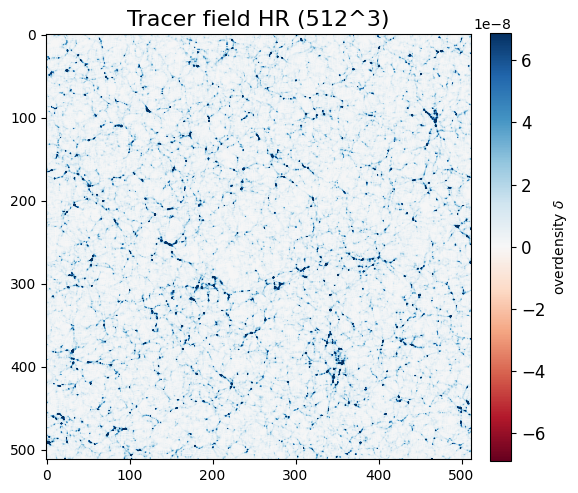

In [94]:
plotter.plot_overdensity_field(tracer_field_hr, title=r'Tracer field HR (512^3)',
                               #vmax=0.1
                               )

0.0 1.2318178121972778e-06
0.0 1.2318178121972778e-06


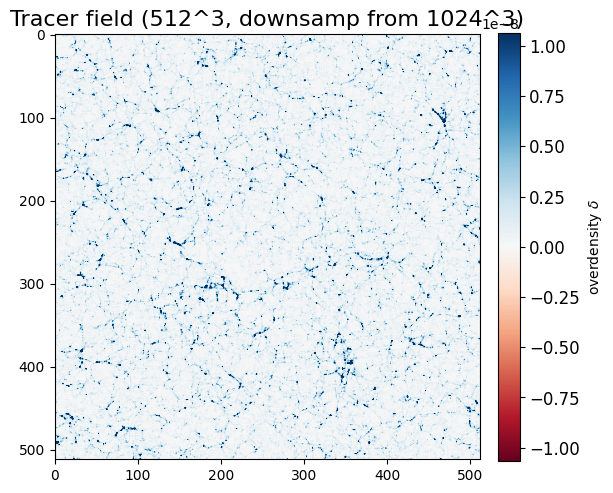

In [96]:
plotter.plot_overdensity_field(tracer_field_finedown_hr, title=r'Tracer field (512^3, downsamp from 1024^3)',
                               #vmax=0.1
                               )

0.0 2.604077963042073e-06
0.0 2.604077963042073e-06


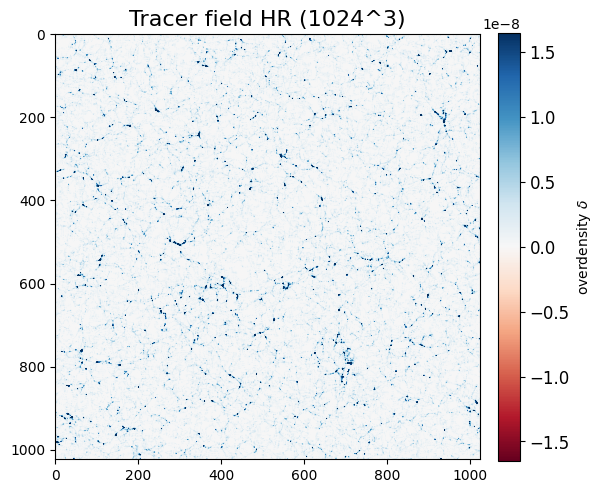

In [95]:
plotter.plot_overdensity_field(tracer_field_fine, title=r'Tracer field HR (1024^3)',
                               #vmax=0.1
                               )

-5.281489393382799e-06 2.2420575987780467e-05
-5.281489393382799e-06 2.2420575987780467e-05


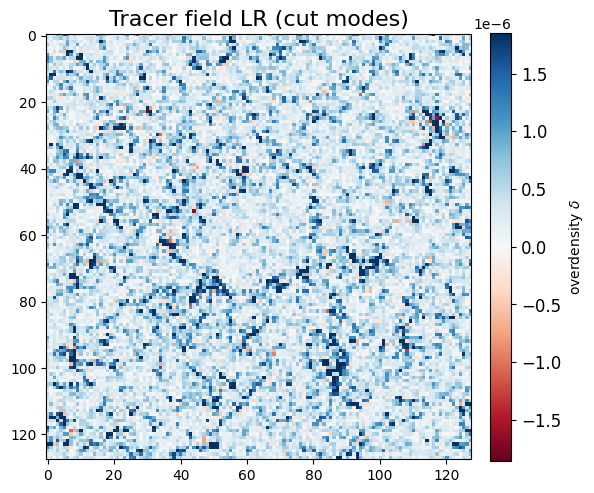

In [89]:
plotter.plot_overdensity_field(tracer_field, title=r'Tracer field LR (cut modes)',
                               #vmax=0.1
                               )

3.18438025048449e-11 7.622522790921653e-08
3.18438025048449e-11 7.622522790921653e-08


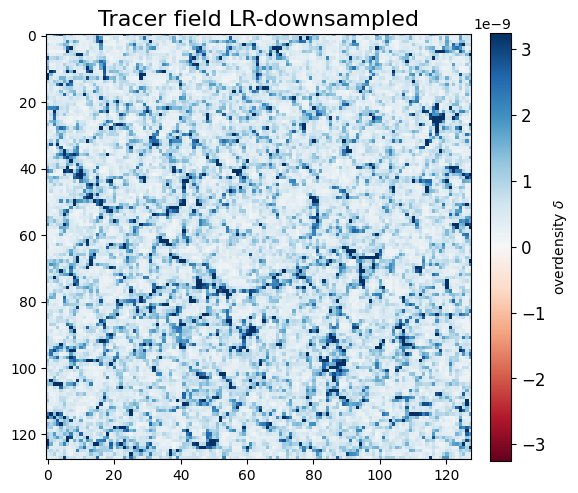

In [90]:
plotter.plot_overdensity_field(tracer_field_finedown, title=r'Tracer field LR-downsampled',
                               #vmax=0.1
                               )

In [72]:
kk = pk_obj_mesh_fromdisp_hr['k']
param_names_fromdict = list(param_dict.keys())

#for param_name in param_names:
for param_name in param_names_fromdict:
    if param_name=='omega_m':
        # no neutrinos, so omega_cold = omega_m
        emu_param_name = 'omega_cold'
    elif param_name=='seed':
        continue
    else:
        emu_param_name = param_names_2_emu_param_names[param_name]
    cosmo_params[emu_param_name] = param_dict[param_name]

_, pk_emu, = emu_mpk_ext.get_nonlinear_pk(k=kk, cold=True,
                                                        **cosmo_params)

/tmp/ipykernel_96533/125363018.py:84: RuntimeWarning: divide by zero encountered in divide
  ax1.plot(ks[i], (pk_emu-pks[i])/errs[i], ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i])
/tmp/ipykernel_96533/125363018.py:85: RuntimeWarning: divide by zero encountered in divide
  ax2.plot(ks[i], (pk_emu/pks[i]), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i])


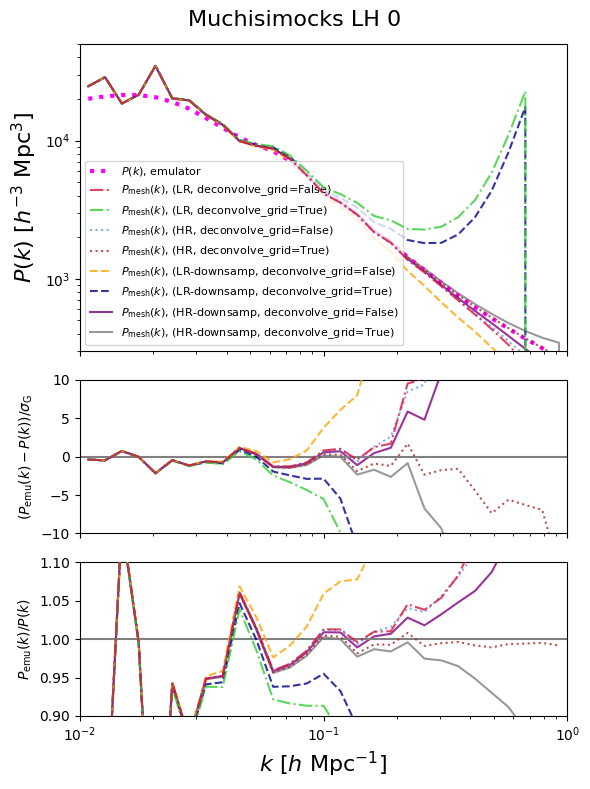

In [97]:
nrows, ncols = 3, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(6,8), sharex=True, height_ratios=[2,1,1])
plt.subplots_adjust(hspace=0.01, wspace=0.01)
ax, ax1, ax2 = axarr
alpha = 0.8

# labels = [r'$P_\text{part}(k)$ (deconvolve_grid=False)', 
#           #r'$P_\text{mesh}(k)$ (deconvolve_grid=False)', 
#           r'$P_\text{part}(k)$ (deconvolve_grid=True)',
#           r'$P_\text{part}(k)$ (deconvolve_grid=True,'+'\n interlacing=True)',
#           r'$P_\text{part}(k)$ (deconvolve_grid=True,'+'\n correct_grid=False)',
#           r'$P_\text{mesh}(k)$ (deconvolve_grid=True)',
#           r'$P_\text{part}(k)$ (deconvolve_grid=True),'+'\n from Quijote snapshot',
#           ]
labels = [ #r'$P_\text{mesh}(k)$, from disp (HR, deconvolve_grid=False)',
          #r'$P_\text{mesh}(k)$, from disp (HR, deconvolve_grid=True)',
          r'$P_\text{mesh}(k)$, (LR, deconvolve_grid=False)',
          r'$P_\text{mesh}(k)$, (LR, deconvolve_grid=True)',
          r'$P_\text{mesh}(k)$, (HR, deconvolve_grid=False)',
          r'$P_\text{mesh}(k)$, (HR, deconvolve_grid=True)',
          r'$P_\text{mesh}(k)$, (LR-downsamp, deconvolve_grid=False)',
          r'$P_\text{mesh}(k)$, (LR-downsamp, deconvolve_grid=True)',
          r'$P_\text{mesh}(k)$, (HR-downsamp, deconvolve_grid=False)',
          r'$P_\text{mesh}(k)$, (HR-downsamp, deconvolve_grid=True)',
        #   r'$P_\text{mesh}(k)$ (LR, deconvolve_grid=False)',
        #   r'$P_\text{mesh}(k)$ (LR, deconvolve_grid=True)',
        #   #r'$P_\text{mesh}(k)$ (deconvolve_grid=True, correct_grid=True)',
        #   r'$P_\text{mesh}(k)$ (HR, deconvolve_grid=False)',
        #   r'$P_\text{mesh}(k)$ (HR, deconvolve_grid=True)'
          ]
colors = ['crimson', 'limegreen', 'cornflowerblue', 'brown', 'orange', 'darkblue', 'purple', 'grey']
lss = ['-.', '-.', ':', ':', '--', '--', '-', '-']
# pk_objs = [pk_obj_particles_nodeconv,
#            pk_obj_particles,
#            pk_obj_particles_interlacing,
#            pk_obj_particles_nocorrectgrid,
#            pk_obj_mesh, 
#            #pk_obj_particles_deconv_Mpcperh, 
#            #pk_obj_pos_mesh_deconv, 
#            pk_obj_snap,
#            ]
pk_objs = [#pk_obj_mesh_fromdisp_hr_deconvolveFalse,
           #pk_obj_mesh_fromdisp_hr,
           pk_obj_mesh_fromdisp_tracer_deconvolveFalse,
           pk_obj_mesh_fromdisp_tracer,
           pk_obj_mesh_fromdisp_tracer_hr_deconvolveFalse,
           pk_obj_mesh_fromdisp_tracer_hr,
           pk_obj_mesh_finedown_deconvolveFalse,
           pk_obj_mesh_finedown,
           pk_obj_mesh_finedown_hr_deconvolveFalse,
           pk_obj_mesh_finedown_hr
        #    pk_obj_mesh_deconvolveFalse,
        #    pk_obj_mesh,
        #    #pk_obj_mesh_correctgridTrue,
        #    pk_obj_mesh_hr_deconvolveFalse,
        #    pk_obj_mesh_hr
           ]
zorders = list(range(len(pk_objs),0,-1))
ks = [pk_obj['k'] for pk_obj in pk_objs]
pks = [pk_obj['pk'] for pk_obj in pk_objs]
errs = [pk_obj['pk_gaussian_error'] for pk_obj in pk_objs]

# ks.append(k_quijote)
# pks.append(pk_quijote)
# errs.append(err_quijote)
# #errs.append(bacco.statistics.approx_pk_gaussian_error(k_quijote, pk_quijote, box_size))
# labels.append(r'$P(k)$, Quijote measured')
# colors.append('grey')
# lss.append('-')
# zorders.append(0)

plt.suptitle(f'Muchisimocks LH {idx_LH_str}', fontsize=16)

ax.loglog(kk, pk_emu, label=r'$P(k)$, emulator', ls=':', color='magenta', lw=3)

for i in range(len(pks)):
    ax.loglog(ks[i], pks[i], ls=lss[i], label=labels[i], color=colors[i], alpha=alpha, zorder=zorders[i])
    if len(pk_emu)!=len(pks[i]):
        pk_interp = np.interp(kk, ks[i], pks[i])
        err_interp = np.interp(kk, ks[i], errs[i])
        ax1.plot(kk, (pk_emu-pk_interp)/err_interp, ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i])
        ax2.plot(kk, (pk_emu/pk_interp), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i])
    else:
        ax1.plot(ks[i], (pk_emu-pks[i])/errs[i], ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i])
        ax2.plot(ks[i], (pk_emu/pks[i]), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i])


ax1.axhline(0.0, color='grey')
ax2.axhline(1.0, color='grey')

ax2.set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=16)
ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)
ax1.set_ylabel(r'$(P_\text{emu}(k)-P(k))/\sigma_\text{G}$')
ax2.set_ylabel(r'$P_\text{emu}(k)/P(k)$')
ax.set_xlim(1e-2, 1)
ax.set_ylim(3e2, 5e4)

ax1.set_ylim(-10, 10)
ax2.set_ylim(0.9, 1.1)

ax.legend(fontsize=8, loc='lower left')

mpl.pyplot.tight_layout()
mpl.pyplot.show()

### Marcos's code

2024-06-13 15:28:14,366 bacco.cosmo :    initialization took 0.000 secs


[0.26844363 0.75660611 0.75117023 0.049      0.9624     0.        ]


2024-06-13 15:28:14,833 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2024-06-13 15:28:14,923 bacco.cosmo :    computed CAMB power spectrum at z=0.00 in 0.089 secs
2024-06-13 15:28:14,996 bacco.cosmo :    created Pk(z=0) tab from k 6.656281038885936e-05 to 100000.0 h/Mpc
2024-06-13 15:28:15,070 bacco.cosmo :    computed halofit at z=0.00 for 'Default' in 0.002 secs


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 48; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.024964 sec
bacco.power : Counting modes


2024-06-13 15:28:15,599 bacco.statistics :  ...done in 0.766 s


bacco.power : done counting modes in 0.392598 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000808 secs
bacco.power : Deallocating arrays
Loading l-bias lpt emulator...


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 whe

L-bias lpt emulator loaded in memory.
Loading smeared bao emulator...
Smeared bao emulator loaded in memory.
Loading non-linear l-bias emulator...


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.23.

Nonlinear l-bias emulator loaded in memory.
HIIII


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


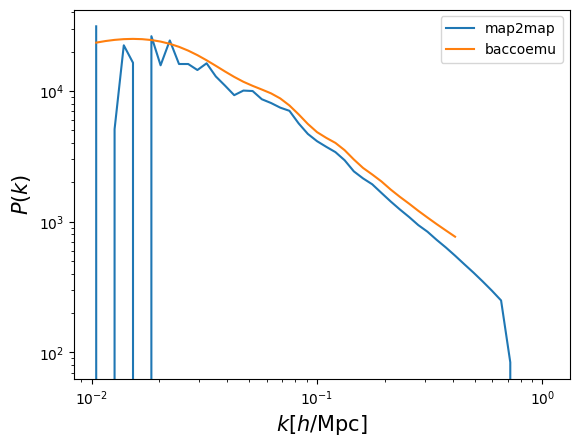

In [9]:

fields_0 = np.load('/cosmos_storage/cosmosims/map2map_cosmolib/LH0//Eulerian_fields_0.npy')
#cosmo = np.loadtxt('/cosmos_storage/cosmosims/map2map_cosmolib/LH0//cosmo_0.txt')
cospars = np.loadtxt('/cosmos_storage/cosmosims/map2map_cosmolib/LH0//cosmo_0.txt')
print(cospars)

# order of cosmo_0.txt
# param_names = ['omega_cold', 'sigma_8', 'h', 'omega_baryon', 'n_s', 'seed']
# order of pars arr
# pars_arr = np.array([Omega0, OmegaBaryon, HubbleParam, ns, sigma8])

Omega0 = cospars[0]
sigma8 = cospars[1] #0.834
HubbleParam = cospars[2] #0.6711
OmegaBaryon = cospars[3] #0.049
ns = cospars[4] #0.9624

pars_arr = np.array([Omega0, OmegaBaryon, HubbleParam, ns, sigma8])

boxsize=1000
expfactor = 1

OmegaLambda = 1 - Omega0

pars = {'omega_cdm':Omega0-OmegaBaryon,
        'omega_de':OmegaLambda, 
        'omega_baryon':OmegaBaryon, 'hubble':HubbleParam, 
        'neutrino_mass':0.0, 'sigma8':sigma8, 'ns':ns, 'expfactor':expfactor}
cosmo = bacco.Cosmology(**pars) #bacco.Cosmology(**bacco.cosmo_parameters.Planck13) 

args_power = {'box':boxsize,
                  'cosmology':cosmo,
                  'interlacing':False,
                  'kmin':0.01,
                  'kmax':1,
                  'nbins':50,
                  'correct_grid':True,
                  'log_binning':True,
                  'deposit_method':'cic',
                  'compute_correlation':False,
                  'zspace':False,
                  'compute_power2d':False}

ngrid=128
power11 = bacco.statistics.compute_crossspectrum_twogrids(grid1=fields_0[0]/512**3,
                                                    grid2=fields_0[0]/512**3,
                                                        ngrid=ngrid,
                                                    normalise_grid1=False,
                                                    normalise_grid2=False,
                                                    deconvolve_grid1=False,
                                                    deconvolve_grid2=False,
                                                    **args_power)

import baccoemu as baccoemu
lbias = baccoemu.Lbias_expansion(verbose=False)

params = {
    'omega_cold'    :  Omega0,
    'sigma8_cold'   :  sigma8, # if A_s is not specified
    'omega_baryon'  :  OmegaBaryon,
    'ns'            :  ns,
    'hubble'        :  HubbleParam,
    'neutrino_mass' :  0.0,
    'w0'            : -1.0,
    'wa'            :  0.0,
    'expfactor'     :  1
}


k, pk_nl_cold = lbias.get_nonlinear_pnn(k=power11['k'][:-10], cold=True, **params)

plt.loglog(power11['k'],power11['pk'], label='map2map')
plt.loglog(k,pk_nl_cold[0], label='baccoemu')
plt.legend()
plt.xlabel(r'$k[h$/Mpc]', size=15)
plt.ylabel(r'$P(k)$', size=15)
plt.show()